<a href="https://colab.research.google.com/github/LindaLeuf/Test/blob/main/aufbereitung_mikrokosmos_V3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Informationen zum Notebook

<p>Herausgeber:  Tobias Vetterle, André Förster, Anna Hinzen, Fachstelle kommunales Bildungsmonitoring (KOSMO)</p>
<p>Version: 3.2.0 (02.07.2024)<p/>

<p>Dieses Notebook dient dazu, Gemeindedaten der Bundesagentur fuer Arbeit (BA) mit Bevoelkerungsdaten des Statistischen Bundesamtes (Destatis) aus den Jahren 2014 bis 2021 zu verknuepfen, um daraus die Entwicklung gemeindespezifischer SGB II-Quoten berechnen und klassifiziert auf einem Dashboard abbilden zu koennen. Hierbei wird auf folgende Originaldaten der BA und von Destatis zugegriffen, die von den entsprechenden Stellen bezogen werden koennen: </p>

- Statistik der Bundesagentur fuer Arbeit, Auftragsnummer 338634, Teil 1-5 (Eckwerte der Grundsicherung nach Gemeinden, Gebietsstand Dezember des jeweiligen Jahres, Jahresdurchschnittswerte, Datenstand: Maerz 2023, Daten zu Leistungen nach dem SGB II nach einer Wartezeit von 3 Monaten)
- Statistisches Bundesamt (Destatis), Bevoelkerungszahlen auf Gemeindeebene nach Geschlecht und Alter (Fortschreibung Zensus 2011, Stichtagsdaten zum 31.12. fuer Gebietsstand und Bevoelkerungszahl des jeweiligen Berichtsjahres (2014-2021))

Um die Aufbereitung der Daten korrekt durchfuehren zu koennen, muessen diese Notebook-Datei (.ipynb) sowie die Originaldaten bzw. -dateien der BA und von Destatis in einem lokalen Ordner gespeichert werden.

## CHANGE LOG des Updates von V 3.1 auf 3.2 – Anpassung für Google Colab, aktualisierte Daten

**Autor:** Tobias Vetterle  
**Datum:** 25.06.2025

---

### Übersicht der Änderungen:

0. **Erweiterung der Datenbasis um die Jahrgänge 2022 und 2023, Anpassung der Berechnungen**
   - Zeilen ergänzt, welche die neuen Datentabellen für BA- und Destatis-Daten der Jahrgänge 2022 und 2023 ins Notebook laden.
   - Sämtliche Operationen, die auf dataframes mit Daten des Jahrgangs 2021 verwiesen, mit den neuen dataframes für 2023 ersetzt.

1. **Einbindung von Google Drive**
   - Nutzung von `drive.mount('/content/drive')` zur Integration des Google Drive.
   - Definition eines Basisverzeichnisses (`base_path`) zur systematischen Pfadsteuerung.

2. **Pfade und Dateizugriff**
   - Für Einbindung von Google Drive alle relativen Dateipfade durch vollständige Pfade mit `base_path` ersetzt.
   - Einsatz von `os.path.join()` für systemunabhängige Pfadkonstruktion.

3. **Excel-Verarbeitung (`transform_dataframe`)**
   - Fehlerhafte Verwendung von `str.split(' ', 1, True)` korrigiert → `str.split(' ', n=1, expand=True)`.
   - Veraltetes Argument `inplace=True` bei `set_axis()` entfernt.

4. **Datenumformung (`apply_transformation`)**
   - Veraltete Methode `DataFrame.append()` durch `pd.concat([...], ignore_index=True)` ersetzt.

5. **CSV-Verarbeitung mit `glob`**
   - Suche nach CSV-Dateien angepasst: `glob.glob(os.path.join(base_path, 'bevoelkerung_alter_geschlecht_*.csv'))`.
   - Extraktion des Dateinamens mit `os.path.basename()` zur robusten Jahr-Zuordnung.
   - Schleifenstruktur vereinfacht (Verzicht auf wiederholtes `for df in [...]`).

6. **Dateiexport**
   - Für den Export einer in Tableau funktionierenden CSV-Datei werden unmittelbar vor dem Export die Dezimaltrenner von Punkten auf Kommata umgestellt sowie die Angaben zum CSV-Trennzeichen sowie dem Encoding konkretisiert
   - Für eine möglichst schmale, performante Tabelle werden kurz vor dem Exprt außerdem die nicht mehr benötigten Spalten mit den vorberechneten Quoten entfernt
   - Bezeichnung der finalen Tabellen ergänzt mit Verweis auf die Version des Notebooks, mit dem die Tabelle generiert wurde: Dateiname (sowohl Excel als auch CSV) der einzigen für das Dashboard benötigten Tabelle lauten also in der aktuellen Notebook-Version "sgb_ii_status_dynamik_V3.2"

---

> **Hinweis:**  
> Die Änderungen gewährleisten nun die Ausführung des Notebooks in einer Google-Colab-Umgebung sowie den Zugriff auf Dateien im Google Drive. Für die Ausführung des Notebooks in der Colab-Umgebung von Dritten muss einfach der in der Variable "base_path" (unter "0. Vorbereitung der Daten") definierte Dateipfad so angepasst werden, das er auf den korrekten Speicherort der Excel-Tabellen im Google Drive verweist.


# 0. Vorbereitung der Daten

In [ ]:
# Benoetigte Pakete importieren
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import locale

# Hinweis: die folgende Bibliothek muss manuell installiert werden
get_ipython().system('pip install mapclassify')
from mapclassify import NaturalBreaks
from mapclassify import FisherJenksSampled
from mapclassify import FisherJenks

# Warnmeldungen unterdruecken
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
# Begrenzung der Spaltendarstellung deaktivieren
pd.set_option("display.max_columns", None)

In [ ]:
# Verbinde Google Drive mit dem Notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Basisverzeichnis definieren (NEU)
base_path = '/content/drive/MyDrive/Dashboard Mikrokosmos/Aktuelle Version 3.7.25/'

# Einlesen der Gemeindedaten der Bundesagentur fuer Arbeit (BA) aus den Jahren 2014 bis 2023
# Dateinamen und Tabellennamen abrufen
file_names = [
    ("230328_EA_338634_Gemeindedaten_Teil1.xlsx", "2014"),
    ("230328_EA_338634_Gemeindedaten_Teil2.xlsx", "2015"),
    ("230328_EA_338634_Gemeindedaten_Teil2.xlsx", "2016"),
    ("230328_EA_338634_Gemeindedaten_Teil3.xlsx", "2017"),
    ("230328_EA_338634_Gemeindedaten_Teil3.xlsx", "2018"),
    ("230328_EA_338634_Gemeindedaten_Teil4.xlsx", "2019"),
    ("230328_EA_338634_Gemeindedaten_Teil4.xlsx", "2020"),
    ("230328_EA_338634_Gemeindedaten_Teil5.xlsx", "2021"),
    ("230328_EA_338634_Gemeindedaten_Teil5.xlsx", "2022"),
    ("241014_EA_360694_Gemeindedaten.xlsx", "2023")
]

# Dictionary fuer die Dataframes erstellen
dataframes = {}

# Modul zum Prüfen, ob Datei existiert (NEU)
import os

# Ueber Dateien und Tabellennamen iterieren
for file_name, sheet_name in file_names:
    full_path = os.path.join(base_path, file_name)  # Absoluten Pfad zusammensetzen (NEU)
    if os.path.exists(full_path):  # Existenz prüfen (NEU)
        # Spezifisches Tabellenblatt in einen DataFrame einlesen
        df = pd.read_excel(full_path, sheet_name=sheet_name)
        # DataFrame im Dictionary speichern
        dataframes["ba_" + sheet_name] = df
    else:
        print(f"Datei nicht gefunden: {full_path}")  # Warnung ausgeben, falls Datei fehlt (NEU)

# Zugriff auf die Dataframes
ba_2014 = dataframes["ba_2014"]
ba_2015 = dataframes["ba_2015"]
ba_2016 = dataframes["ba_2016"]
ba_2017 = dataframes["ba_2017"]
ba_2018 = dataframes["ba_2018"]
ba_2019 = dataframes["ba_2019"]
ba_2020 = dataframes["ba_2020"]
ba_2021 = dataframes["ba_2021"]
ba_2022 = dataframes["ba_2022"]
ba_2023 = dataframes["ba_2023"]


In [ ]:
# Tabellenkopf bis zum Beginn des Datenbereichs in Zeile 15 anzeigen
ba_2023.head(15)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Grundsicherung für Arbeitsuchende (SGB II)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eckwerte der Grundsicherung nach Gemeinden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Deutschland - Gemeinden (Gebietsstand Dezember...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Jahresdurchschnitt 2023, Datenstand: September...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Daten zu Leistungen nach dem SGB II nach einer...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Gemeinde,Leistungs-berechtigte (LB),Insgesamt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,davon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Männer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Frauen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,dar. (Sp. 1) im Alter von ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dar. (Sp. 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leistungs-berechtigte (LB),dar. (Sp. 25) im Alter von ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dar. (Sp

# 1. BA-Daten umformen

## 1.1 Grundlegende Umformung der Ausgangsdaten

In [ ]:
# Funktion zur Transformation der Daten definieren
def transform_dataframe(df):
    # Zeilen 0 bis 7 entfernen
    df = df.drop(df.index[0:7])

    # Letzte Zeile entfernen
    df = df.drop(df.index[-1])

    # Spalte 'Unnamed: 0' nach Leerzeichen trennen und in neue Spalten 'AGS' und 'Gemeinde' aufteilen
    df[['AGS', 'Gemeinde']] = df['Unnamed: 0'].str.split(' ', n=1, expand=True)  # Korrektur: benannte Argumente (NEU)

    # Spalte 'Unnamed: 0' entfernen
    df = df.drop(['Unnamed: 0'], axis=1)

    # Erstellen einer Kontrollspalte 'Gesamtwerte_Kontrolle' mit den Spalten 'AGS', 'Gemeinde' und 'Unnamed: 1'
    Gesamtwerte_Kontrolle = df[['AGS', 'Gemeinde', 'Unnamed: 1']].copy()

    # Spalte 'Unnamed: 1' entfernen
    df.drop(['Unnamed: 1'], axis=1, inplace=True)

    # Nur Spalten ab der 23. Spalte behalten
    df = df.iloc[:, 23:]

    # Fehlende Werte in Zeile 5 mit den Werten der vorherigen Zeilen fuellen
    df.iloc[5] = df.iloc[5].fillna(df.iloc[4])
    df.iloc[5] = df.iloc[5].fillna(df.iloc[3])
    df.iloc[5] = df.iloc[5].fillna(df.iloc[2])

    # Zeilen 7, 9, 10, 11 und 13 entfernen
    df = df.drop([7, 9, 10, 11, 13])

    # Letzte beiden Werte in Zeile 1 mit den Werten der letzten beiden Spaltennamen fuellen
    df.iloc[1, -1] = df.columns[-1]
    df.iloc[1, -2] = df.columns[-2]

    # Neue Spaltennamen aus Zeile 1 erstellen
    new_columns = df.iloc[1].tolist()

    # Spaltennamen aktualisieren (KORREKTUR: inplace entfernt) (NEU)
    df = df.set_axis(new_columns, axis=1)

    # Zeile 12 entfernen
    df = df.drop(12)

    # Transformiertes DataFrame zurueckgeben
    return df

# Definierte Funktion auf die Daten anwenden und damit Dataframes erstellen
ba_2014 = transform_dataframe(ba_2014)
ba_2015 = transform_dataframe(ba_2015)
ba_2016 = transform_dataframe(ba_2016)
ba_2017 = transform_dataframe(ba_2017)
ba_2018 = transform_dataframe(ba_2018)
ba_2019 = transform_dataframe(ba_2019)
ba_2020 = transform_dataframe(ba_2020)
ba_2021 = transform_dataframe(ba_2021)
ba_2022 = transform_dataframe(ba_2022)
ba_2023 = transform_dataframe(ba_2023)


In [ ]:
# Tabellenkopf nach der Umformung anzeigen
ba_2023.head(2)

,Leistungs-berechtigte (LB),unter 65 Jahren,unter 15 Jahren,unter 3 Jahren,3 bis unter 6 Jahren,6 bis unter 15 Jahren,15 bis unter 18 Jahren,18 bis unter 25 Jahren,25 bis unter 65 Jahren,15 bis unter 18 Jahren (Kinder),Erwerbs-fähige Leistungs-berechtigte (ELB),erziehende ELB,allein-erziehende ELB,arbeit-suchende ELB insgesamt,kein Hauptschul-abschluss,Hauptschul-abschluss,mittlere Reife,Fachhoch-schule,Abitur/ Hochschul-reife,keine Angabe,ohne abge-schlossene Berufs-ausbildung,betriebliche/schulische Ausbildung,akade-mische Ausbildung,keine Angabe,Leistungs-berechtigte (LB),unter 65 Jahren,unter 15 Jahren,unter 3 Jahren,3 bis unter 6 Jahren,6 bis unter 15 Jahren,15 bis unter 18 Jahren,18 bis unter 25 Jahren,25 bis unter 65 Jahren,15 bis unter 18 Jahren (Kinder),Erwerbs-fähige Leistungs-berechtigte (ELB),erziehende ELB,allein-erziehende ELB,arbeit-suchende ELB insgesamt,kein Hauptschul-abschluss,Hauptschul-abschluss,mittlere Reife,Fachhoch-schule,Abitur/ Hochschul-reife,keine Angabe,ohne abge-schlossene Berufs-ausbildung,betriebliche/schulische Ausbildung,akade-mische Ausbildung,keine Angabe,AGS,Gemeinde
8,Männer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Frauen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,4992.416667,4960.25,1385.916667,289.5,329.25,767.166667,209.916667,520.833333,2843.583333,202.166667,3549.75,770.5,109.916667,2627.666667,502.083333,911.666667,385.666667,102.333333,309.333333,416.583333,1798.333333,681.333333,147.416667,0.583333,5151.5,5129.416667,1384.666667,257.75,330.166667,796.75,225.916667,567.583333,2951.25,217.666667,3704.25,1697.416667,1011.416667,2298.916667,362.333333,669.916667,381.166667,69.416667,318.083333,498,1515.5,577.583333,205.5,0.333333,01001000,"Flensburg, Stadt"


## 1.2 Spalte fuer Geschlecht ergaenzen und Tabelle entsprechend stapeln

In [ ]:
# Funktion zur Transformation der Daten definieren
def apply_transformation(df):
    # Daten (maennlich) aus den ersten 24 Spalten und den Spalten 48 und 49 extrahieren
    df_m = df.iloc[:, list(range(24)) + [48, 49]]

    # Daten (weiblich) aus den Spalten 24 bis 49 extrahieren
    df_w = df.iloc[:, 24:50]

    # Geschlecht fuer Daten (weiblich) auf "w" setzen
    df_w.loc[:, "Geschlecht"] = "w"

    # Geschlecht fuer Daten (maennlich) auf "m" setzen
    df_m.loc[:, "Geschlecht"] = "m"

    # Zeile 8 aus Daten (weiblich) entfernen
    df_w = df_w.drop([8])

    # Zeile 8 aus Daten (maennlich) entfernen
    df_m = df_m.drop([8])

    # Daten (maennlich und weiblich) zu einem DataFrame kombinieren (KORREKTUR: pd.concat statt append) (NEU)
    combined_df = pd.concat([df_m, df_w], ignore_index=True)

    # Spalten umbenennen, indem Bindestriche "-" entfernt werden
    combined_df = combined_df.rename(columns=lambda x: x.replace('-', ''))

    return combined_df

# Definierte Funktion auf die Daten anwenden und damit Dataframes transformieren
ba_2014_combined = apply_transformation(ba_2014)
ba_2015_combined = apply_transformation(ba_2015)
ba_2016_combined = apply_transformation(ba_2016)
ba_2017_combined = apply_transformation(ba_2017)
ba_2018_combined = apply_transformation(ba_2018)
ba_2019_combined = apply_transformation(ba_2019)
ba_2020_combined = apply_transformation(ba_2020)
ba_2021_combined = apply_transformation(ba_2021)
ba_2022_combined = apply_transformation(ba_2022)
ba_2023_combined = apply_transformation(ba_2023)


In [ ]:
# Tabellenkopf nach der Umformung anzeigen
ba_2023_combined.head(1)

,Leistungsberechtigte (LB),unter 65 Jahren,unter 15 Jahren,unter 3 Jahren,3 bis unter 6 Jahren,6 bis unter 15 Jahren,15 bis unter 18 Jahren,18 bis unter 25 Jahren,25 bis unter 65 Jahren,15 bis unter 18 Jahren (Kinder),Erwerbsfähige Leistungsberechtigte (ELB),erziehende ELB,alleinerziehende ELB,arbeitsuchende ELB insgesamt,kein Hauptschulabschluss,Hauptschulabschluss,mittlere Reife,Fachhochschule,Abitur/ Hochschulreife,keine Angabe,ohne abgeschlossene Berufsausbildung,betriebliche/schulische Ausbildung,akademische Ausbildung,keine Angabe,AGS,Gemeinde,Geschlecht
0,4992.416667,4960.25,1385.916667,289.5,329.25,767.166667,209.916667,520.833333,2843.583333,202.166667,3549.75,770.5,109.916667,2627.666667,502.083333,911.666667,385.666667,102.333333,309.333333,416.583333,1798.333333,681.333333,147.416667,0.583333,01001000,"Flensburg, Stadt",m


## 1.3 Gestapelte Zieltabellen erstellen

#### Die Tabelle enthaelt zum jetzigen Zeitpunkt Daten zu den Leistungsberechtigten (LB) nach Geschlecht und Altersgruppen, zu den arbeitsuchenden erwerbsfaehigen Leistungsberechtigten (ELB) nach Geschlecht und Schulabschluessen sowie zu den arbeitsuchenden ELB nach Geschlecht und Berufsausbildung. Wir teilen die Tabelle in drei separate Tabellen zu diesen Kennzahlen auf, um sie im weiteren Verlauf zielgerichtet bearbeiten zu koennen.

 - Ein Dataframe (DF) mit Leistungsberechtigten (LB) nach Geschlecht und Altersgruppen, das sich auf Anzahl der LB aggregieren laesst
     - Spalte "LB unter 15 Jahren" loeschen, da aus anderen Spalten summierbar
     - Spalte "LB unter 65 Jahren" loeschen, da aus anderen Spalten summierbar
     - Spalte "15 bis unter 18 Jahren (Kinder)" loeschen
 - Ein DF mit arbeitsuchenden erwerbsfaehigen Leistungsberechtigten (ELB) nach Geschlecht und Schulabschluessen (Unterscheidung Schulabschluesse nur fuer "arbeitsuchende ELB" moeglich)
     - Spalten 15 - 20 in der Ausgangsdatei
 - Ein DF mit arbeitsuchenden ELB nach Geschlecht und Berufsausbildung (Unterscheidung Berufsausbildung nur fuer "arbeitsuchende ELB" moeglich)
     - Spalten 21- 24 in der Ausgangsdatei

In [ ]:
# Funktion zur Transformation der Daten definieren
def apply_transformation(df, year):
    # relevante Spalten aus dem kombinierten Dataframe extrahieren
    LB_nach_Altersgruppen = df.iloc[:, [3, 4, 5, 6, 7, 8, 24, 25, 26]].copy()

    # Datensatz in langes Format umwandeln, indem Altersgruppen in separate Spalte transformiert werden
    LB_nach_Altersgruppen = pd.melt(LB_nach_Altersgruppen, id_vars=['AGS', 'Gemeinde', 'Geschlecht'], value_vars=['unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren', '15 bis unter 18 Jahren', '18 bis unter 25 Jahren', '25 bis unter 65 Jahren'], var_name='Altersgruppe', value_name='Anzahl')

    # Spalte hinzufuegen, um das Jahr zu speichern
    LB_nach_Altersgruppen['Jahr'] = year

    # Spalten "AGS" und "Jahr" in Ganzzahlen umwandeln
    LB_nach_Altersgruppen["AGS"] = pd.to_numeric(LB_nach_Altersgruppen["AGS"], downcast="integer")
    LB_nach_Altersgruppen["Jahr"] = pd.to_numeric(LB_nach_Altersgruppen["Jahr"], downcast="integer")

    # gleicher Vorgang fuer arbeitsuchende ELB nach Schulabschluessen
    ELB_arbeitsuchend_nach_Schulabschluessen = df.iloc[:, [13, 14, 15, 16, 17, 18, 19, 24, 25, 26]].copy()
    ELB_arbeitsuchend_nach_Schulabschluessen = pd.melt(ELB_arbeitsuchend_nach_Schulabschluessen, id_vars=['AGS', 'Gemeinde', 'Geschlecht', 'arbeitsuchende ELB insgesamt'], value_vars=['kein Hauptschulabschluss', 'Hauptschulabschluss', 'mittlere Reife', 'Fachhochschule', 'Abitur/ Hochschulreife', 'keine Angabe'], var_name='Schulabschluss', value_name='Anzahl')
    ELB_arbeitsuchend_nach_Schulabschluessen['Jahr'] = year
    ELB_arbeitsuchend_nach_Schulabschluessen["AGS"] = pd.to_numeric(ELB_arbeitsuchend_nach_Schulabschluessen["AGS"], downcast="integer")
    ELB_arbeitsuchend_nach_Schulabschluessen["Jahr"] = pd.to_numeric(ELB_arbeitsuchend_nach_Schulabschluessen["Jahr"], downcast="integer")

    # gleicher Vorgang fuer die ELB arbeitsuchend nach Berufsausbildung
    ELB_arbeitsuchend_nach_Berufsausbildung = df.iloc[:, [13, 20, 21, 22, 23, 24, 25, 26]].copy()
    ELB_arbeitsuchend_nach_Berufsausbildung = pd.melt(ELB_arbeitsuchend_nach_Berufsausbildung, id_vars=['AGS', 'Gemeinde', 'Geschlecht', 'arbeitsuchende ELB insgesamt'], value_vars=['ohne abgeschlossene Berufsausbildung', 'betriebliche/schulische Ausbildung', 'akademische Ausbildung', 'keine Angabe'], var_name='Berufsausbildung', value_name='Anzahl')
    ELB_arbeitsuchend_nach_Berufsausbildung['Jahr'] = year
    ELB_arbeitsuchend_nach_Berufsausbildung["AGS"] = pd.to_numeric(ELB_arbeitsuchend_nach_Berufsausbildung["AGS"], downcast="integer")
    ELB_arbeitsuchend_nach_Berufsausbildung["Jahr"] = pd.to_numeric(ELB_arbeitsuchend_nach_Berufsausbildung["Jahr"], downcast="integer")

    # Rueckgabe der Ergebnisse in separaten Dataframes
    return LB_nach_Altersgruppen, ELB_arbeitsuchend_nach_Schulabschluessen, ELB_arbeitsuchend_nach_Berufsausbildung

# Definierte Funktion auf die Daten anwenden und damit Dataframes transformieren
LB_nach_Altersgruppen_2014, ELB_arbeitsuchend_nach_Schulabschluessen_2014, ELB_arbeitsuchend_nach_Berufsausbildung_2014 = apply_transformation(ba_2014_combined, 2014)
LB_nach_Altersgruppen_2015, ELB_arbeitsuchend_nach_Schulabschluessen_2015, ELB_arbeitsuchend_nach_Berufsausbildung_2015 = apply_transformation(ba_2015_combined, 2015)
LB_nach_Altersgruppen_2016, ELB_arbeitsuchend_nach_Schulabschluessen_2016, ELB_arbeitsuchend_nach_Berufsausbildung_2016 = apply_transformation(ba_2016_combined, 2016)
LB_nach_Altersgruppen_2017, ELB_arbeitsuchend_nach_Schulabschluessen_2017, ELB_arbeitsuchend_nach_Berufsausbildung_2017 = apply_transformation(ba_2017_combined, 2017)
LB_nach_Altersgruppen_2018, ELB_arbeitsuchend_nach_Schulabschluessen_2018, ELB_arbeitsuchend_nach_Berufsausbildung_2018 = apply_transformation(ba_2018_combined, 2018)
LB_nach_Altersgruppen_2019, ELB_arbeitsuchend_nach_Schulabschluessen_2019, ELB_arbeitsuchend_nach_Berufsausbildung_2019 = apply_transformation(ba_2019_combined, 2019)
LB_nach_Altersgruppen_2020, ELB_arbeitsuchend_nach_Schulabschluessen_2020, ELB_arbeitsuchend_nach_Berufsausbildung_2020 = apply_transformation(ba_2020_combined, 2020)
LB_nach_Altersgruppen_2021, ELB_arbeitsuchend_nach_Schulabschluessen_2021, ELB_arbeitsuchend_nach_Berufsausbildung_2021 = apply_transformation(ba_2021_combined, 2021)
LB_nach_Altersgruppen_2022, ELB_arbeitsuchend_nach_Schulabschluessen_2022, ELB_arbeitsuchend_nach_Berufsausbildung_2022 = apply_transformation(ba_2021_combined, 2022)
LB_nach_Altersgruppen_2023, ELB_arbeitsuchend_nach_Schulabschluessen_2023, ELB_arbeitsuchend_nach_Berufsausbildung_2023 = apply_transformation(ba_2021_combined, 2023)

In [ ]:
# Tabellenkopf der Tabelle zu den Leistungsberechtigten anzeigen
LB_nach_Altersgruppen_2023.head(4)

,AGS,Gemeinde,Geschlecht,Altersgruppe,Anzahl,Jahr
0,1001000,"Flensburg, Stadt",m,unter 3 Jahren,359.333333,2023
1,1002000,"Kiel, Landeshauptstadt",m,unter 3 Jahren,852.5,2023
2,1003000,"Lübeck, Hansestadt",m,unter 3 Jahren,587.583333,2023
3,1004000,"Neumünster, Stadt",m,unter 3 Jahren,277.583333,2023


# 2. Bevoelkerungsdaten umformen

#### Nachdem die Daten zu den LB nun in der gewuenschten Form vorliegen, wenden wir uns den Bevoelkerungsdaten zu und formen diese ebenfalls um, sodass sie im naechsten Schritt mit den Daten zu den LB verknuepft werden koennen.

In [ ]:
# glob importieren, falls noch nicht geschehen
import glob
import os

# Liste mit den vollständigen Dateipfaden erstellen (NEU)
file_names = glob.glob(os.path.join(base_path, 'bevoelkerung_alter_geschlecht_*.csv'))

# Bevoelkerungsdaten einlesen und umformen

# Schleife ueber alle Dateien
for file in file_names:
    # Jahreszahl aus dem Dateinamen extrahieren
    year = os.path.basename(file).split('_')[-1].split('.')[0]  # (NEU: nur Dateiname ohne Pfad verwenden)

    # Daten einlesen und jede CSV in einem DataFrame mit der Bezeichnung "bevoelkerung_yyyy" speichern
    df_name = 'bevoelkerung_' + year
    globals()[df_name] = pd.read_csv(file, encoding='ISO-8859-1', delimiter=';')  # (Dateipfad ist nun absolut)

    # Umwandlung der Spalte "Geschlecht"
    df = globals()[df_name]
    df['Geschlecht'] = df['Geschlecht'].astype(str)
    df['Geschlecht'] = df['Geschlecht'].replace({'2': 'w', '1': 'm'})

    # Umwandlung der Spalte "Alter"
    df['Alter'] = df['Alter'].replace({
        'u3': 'unter 3 Jahren',
        '3-u6': '3 bis unter 6 Jahren',
        '6-u15': '6 bis unter 15 Jahren',
        '15-u18': '15 bis unter 18 Jahren',
        '18-u25': '18 bis unter 25 Jahren',
        '25-u65': '25 bis unter 65 Jahren'
    })

    # Entfernung der Zeilen mit nicht gewünschten Alterswerten
    df.drop(df[df['Alter'].isin(['u65', 'ü65', 'insg'])].index, inplace=True)

    # Spaltennamen aendern
    df.rename(columns={
        "Alter": "Altersgruppe",
        "Anzahl": "Anzahl_Bevoelkerung"
    }, inplace=True)


HInzugefügt LL:

In [ ]:
print([v for v in globals() if v.startswith('bevoelkerung_')])

['bevoelkerung_2021', 'bevoelkerung_2016', 'bevoelkerung_2023', 'bevoelkerung_2015', 'bevoelkerung_2014', 'bevoelkerung_2019', 'bevoelkerung_2017', 'bevoelkerung_2018', 'bevoelkerung_2020', 'bevoelkerung_2022']


In [ ]:
# Tabellenkopf der Bevoelkerungsdaten nach der Umformung anzeigen
bevoelkerung_2022.head()

,AGS,Geschlecht,Altersgruppe,Anzahl_Bevoelkerung
1,1001000,m,unter 3 Jahren,1358.0
2,1001000,m,3 bis unter 6 Jahren,1352.0
3,1001000,m,6 bis unter 15 Jahren,3704.0
4,1001000,m,15 bis unter 18 Jahren,1233.0
5,1001000,m,18 bis unter 25 Jahren,4922.0


# 3. Sozial- und Bevoelkerungsdaten zusammenfuegen ("Merge") und Quoten berechnen

## 3.1 Merge

### Plan fuer den Merge (hier fuer 2021, analog auf die uebrigen Jahrgaenge zu uebertragen):

- LB_nach_Altersgruppen_2021 und bevoelkerung_2021:
    - Ziel: Anteil der LB (nach Altersgruppen und Geschlecht) an der jeweiligen Bevoelkerung berechnen
    - Vorbereitung: bevoelkerung_2021 gruppieren nach "AGS" und "Geschlecht", sodass Summe der u65 Jaehrigen gebildet wird fuer SGBII-Quote
    - Merge ueber die Spalten "AGS", "Geschlecht"
- ELB_arbeitsuchend_nach_Berufsausbildung_2021:
    - Ziel: Anteil der arbeitsuchenden ELB nach Berufsausbildung und Geschlecht an der Gesamtzahl der arbeitsuchenden ELB 15-u65 berechnen
    - Kein Merge mit Bevoelkerungsdaten erforderlich
- ELB_arbeitsuchend_nach_Schulabschluessen_2021:
    - Ziel: Anteil der arbeitsuchenden ELB nach Schulabschluss und Geschlecht an der Gesamtzahl der arbeitsuchenden ELB 15-u65 berechnen
    - Kein Merge mit Bevoelkerungsdaten erforderlich

In [ ]:
# Merge der Dataframes fuer 2014
## LB
merged_lb_bev_2014 = LB_nach_Altersgruppen_2014.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])

# Merge der Dataframes fuer die uebrigen Jahre
## LB
merged_lb_bev_2015 = LB_nach_Altersgruppen_2015.merge(bevoelkerung_2015, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2016 = LB_nach_Altersgruppen_2016.merge(bevoelkerung_2016, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2017 = LB_nach_Altersgruppen_2017.merge(bevoelkerung_2017, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2018 = LB_nach_Altersgruppen_2018.merge(bevoelkerung_2018, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2019 = LB_nach_Altersgruppen_2019.merge(bevoelkerung_2019, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2020 = LB_nach_Altersgruppen_2020.merge(bevoelkerung_2020, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2021 = LB_nach_Altersgruppen_2021.merge(bevoelkerung_2021, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2022 = LB_nach_Altersgruppen_2022.merge(bevoelkerung_2022, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2023 = LB_nach_Altersgruppen_2023.merge(bevoelkerung_2023, on=["AGS", "Geschlecht", "Altersgruppe"])

In [ ]:
# Tabellenkopf der zusammengefuegten Tabelle fuer 2021 anzeigen
merged_lb_bev_2023.head(4)

,AGS,Gemeinde,Geschlecht,Altersgruppe,Anzahl,Jahr,Anzahl_Bevoelkerung
0,1001000,"Flensburg, Stadt",m,unter 3 Jahren,359.333333,2023,1303.0
1,1002000,"Kiel, Landeshauptstadt",m,unter 3 Jahren,852.5,2023,3265.0
2,1003000,"Lübeck, Hansestadt",m,unter 3 Jahren,587.583333,2023,2704.0
3,1004000,"Neumünster, Stadt",m,unter 3 Jahren,277.583333,2023,1087.0


## 3.2 Ergebnistabellen stapeln

#### Die Daten liegen aktuell noch in einzelnen Dataframes fuer die jeweiligen Jahrgaenge vor. Wir stapeln diese Dataframes untereinander, um alle Jahrgaenge in einem Dataframe zusammenzufassen.

In [ ]:
stacked_lb_bev = pd.concat([merged_lb_bev_2014, merged_lb_bev_2015, merged_lb_bev_2016, merged_lb_bev_2017, merged_lb_bev_2018, merged_lb_bev_2019, merged_lb_bev_2020, merged_lb_bev_2021, merged_lb_bev_2022, merged_lb_bev_2023], ignore_index=True)
stacked_elb_schul = pd.concat([ELB_arbeitsuchend_nach_Schulabschluessen_2014, ELB_arbeitsuchend_nach_Schulabschluessen_2015, ELB_arbeitsuchend_nach_Schulabschluessen_2016, ELB_arbeitsuchend_nach_Schulabschluessen_2017, ELB_arbeitsuchend_nach_Schulabschluessen_2018, ELB_arbeitsuchend_nach_Schulabschluessen_2019, ELB_arbeitsuchend_nach_Schulabschluessen_2020, ELB_arbeitsuchend_nach_Schulabschluessen_2021, ELB_arbeitsuchend_nach_Schulabschluessen_2022, ELB_arbeitsuchend_nach_Schulabschluessen_2023], ignore_index=True)
stacked_elb_beruf = pd.concat([ELB_arbeitsuchend_nach_Berufsausbildung_2014, ELB_arbeitsuchend_nach_Berufsausbildung_2015, ELB_arbeitsuchend_nach_Berufsausbildung_2016, ELB_arbeitsuchend_nach_Berufsausbildung_2017, ELB_arbeitsuchend_nach_Berufsausbildung_2018, ELB_arbeitsuchend_nach_Berufsausbildung_2019, ELB_arbeitsuchend_nach_Berufsausbildung_2020, ELB_arbeitsuchend_nach_Berufsausbildung_2021, ELB_arbeitsuchend_nach_Berufsausbildung_2022, ELB_arbeitsuchend_nach_Berufsausbildung_2023], ignore_index=True)

In [ ]:
# Tabellenkopf des gestapelten Dataframes fuer die LB mit allen Jahrgaengen anzeigen
stacked_lb_bev.head(1)

,AGS,Gemeinde,Geschlecht,Altersgruppe,Anzahl,Jahr,Anzahl_Bevoelkerung
0,1001000,"Flensburg, Stadt",m,unter 3 Jahren,273.666667,2014,1087.0


In [ ]:
stacked_elb_beruf.head(100)

,AGS,Gemeinde,Geschlecht,arbeitsuchende ELB insgesamt,Berufsausbildung,Anzahl,Jahr
0,1001000,"Flensburg, Stadt",m,3215.666667,ohne abgeschlossene Berufsausbildung,1984.5,2014
1,1002000,"Kiel, Landeshauptstadt",m,9485.75,ohne abgeschlossene Berufsausbildung,5776.25,2014
2,1003000,"Lübeck, Hansestadt",m,7943.333333,ohne abgeschlossene Berufsausbildung,4916.416667,2014
3,1004000,"Neumünster, Stadt",m,2972.75,ohne abgeschlossene Berufsausbildung,1914.166667,2014
4,1051001,Albersdorf,m,110.25,ohne abgeschlossene Berufsausbildung,56.583333,2014
...,...,...,...,...,...,...,...
95,1051113,Wöhrden,m,16.583333,ohne abgeschlossene Berufsausbildung,6,2014
96,1051114,Tellingstedt,m,52.916667,ohne abgeschlossene Berufsausbildung,19.333333,2014
97,1051117,Tielenhemme,m,1.666667,ohne abgeschlossene Berufsausbildung,0,2014
98,1051118,Trennewurth,m,1.166667,ohne abgeschlossene Berufsausbildung,0.666667,2014


## 3.3 Ergebnistabellen Spalten umbennen

In [ ]:
# Umbenennungen im DataFrame "stacked_lb_bev"
stacked_lb_bev = stacked_lb_bev.rename(columns={"Altersgruppe": "Altersgruppe_LB",
                                                "Anzahl": "Anzahl_LB"})

# Umbenennungen im DataFrame "stacked_elb_schul"
stacked_elb_schul = stacked_elb_schul.rename(columns={"arbeitsuchende ELB insgesamt": "arbeitsuchende_elb_insgesamt"})

# Umbenennungen im DataFrame "stacked_elb_beruf"
stacked_elb_beruf = stacked_elb_beruf.rename(columns={"arbeitsuchende ELB insgesamt": "arbeitsuchende_elb_insgesamt"})

## 3.4 Differenzierung nach Geschlecht aufheben

#### Um die Fallzahlen pro Altersgruppe zu erhoehen, wird die Unterscheidung nach Geschlecht aufgehoben

In [ ]:
grouping_columns = ['AGS', 'Gemeinde', 'Altersgruppe_LB', 'Jahr']

# Gruppieren und Summieren
stacked_lb_bev = stacked_lb_bev.groupby(grouping_columns, as_index=False).agg({
    'Anzahl_LB': 'sum',
    'Anzahl_Bevoelkerung': 'sum'
})

In [ ]:
grouping_columns = ['AGS', 'Gemeinde', 'Schulabschluss', 'Jahr']

# Gruppieren und Summieren
stacked_elb_schul = stacked_elb_schul.groupby(grouping_columns, as_index=False).agg({
    'arbeitsuchende_elb_insgesamt': 'sum',
    'Anzahl': 'sum'
})

In [ ]:
grouping_columns = ['AGS', 'Gemeinde', 'Berufsausbildung', 'Jahr']

# Gruppieren und Summieren
stacked_elb_beruf = stacked_elb_beruf.groupby(grouping_columns, as_index=False).agg({
    'arbeitsuchende_elb_insgesamt': 'sum',
    'Anzahl': 'sum'
})

In [ ]:
# Tabellenkopf nach der Aufhebung der Unterscheidung nach Geschlecht anzeigen
stacked_lb_bev.head()

,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung
0,1001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2014,414.083333,2280.0
1,1001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2015,395.25,2315.0
2,1001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2016,396.416667,2343.0
3,1001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2017,427.75,2336.0
4,1001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2018,437.75,2241.0


In [ ]:
stacked_elb_beruf.head()

,AGS,Gemeinde,Berufsausbildung,Jahr,arbeitsuchende_elb_insgesamt,Anzahl
0,1001000,"Flensburg, Stadt",akademische Ausbildung,2014,5832.083333,171.833333
1,1001000,"Flensburg, Stadt",akademische Ausbildung,2015,5795.916667,172.416667
2,1001000,"Flensburg, Stadt",akademische Ausbildung,2016,5762.833333,199.083333
3,1001000,"Flensburg, Stadt",akademische Ausbildung,2017,6009.166667,248.583333
4,1001000,"Flensburg, Stadt",akademische Ausbildung,2018,5930.083333,254.583333


In [ ]:
stacked_elb_schul.head()

,AGS,Gemeinde,Schulabschluss,Jahr,arbeitsuchende_elb_insgesamt,Anzahl
0,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2014,5832.083333,327.166667
1,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2015,5795.916667,333.583333
2,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2016,5762.833333,397.583333
3,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2017,6009.166667,573.333333
4,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2018,5930.083333,612.416667


## 3.5 Altersgruppen zusammenfassen, sodass folgende Altersdifferenzierung uebrig bleibt: 0-u6; 6-u15; 15-u18; 18-u65

#### Um die Fallzahlen pro Altersgruppe weiter zu erhoehen, werden einzelne Altersgruppen zusammengefasst

In [ ]:
unique_ages = stacked_lb_bev["Altersgruppe_LB"].unique()

In [ ]:
# Werte in der Spalte 'Altersgruppe_LB' ersetzen, um anschliessend gruppieren zu koennen
replacement_dict = {
    'unter 3 Jahren': '0 bis unter 6 Jahren',
    '3 bis unter 6 Jahren': '0 bis unter 6 Jahren',
    '18 bis unter 25 Jahren': '18 bis unter 65 Jahren',
    '25 bis unter 65 Jahren': '18 bis unter 65 Jahren'
}

stacked_lb_bev['Altersgruppe_LB'] = stacked_lb_bev['Altersgruppe_LB'].replace(replacement_dict)

# Liste der Spalten, nach denen gruppiert werden soll
grouping_columns = ['AGS', 'Gemeinde', 'Altersgruppe_LB', 'Jahr']

# Gruppieren und Summieren
stacked_lb_bev = stacked_lb_bev.groupby(grouping_columns, as_index=False).agg({
    'Anzahl_LB': 'sum',
    'Anzahl_Bevoelkerung': 'sum'
})

In [ ]:
# Tabellenkopf nach Zusammenfassung einzelner Altersgruppen anzeigen
stacked_lb_bev.head()

,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung
0,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2014,1055.5,4303.0
1,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2015,1115.166667,4504.0
2,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2016,1136.416667,4740.0
3,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2017,1325.166667,4896.0
4,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2018,1446.25,4961.0


## 3.6 SGB-II und ELB Quoten berechnen

#### Nachdem die Tabellen mit den absoluten Werten nun in der gewuenschten Form vorliegen, koennen die Quoten berechnet werden

In [ ]:
# Bevoelkerungsdaten enthalten Zeilen, in denen die jeweilige Bevoelkerung = 0 ist; daher Zeilen mit Bevoelkerung = 0 aus Bevoelkerungsdaten entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_lb_bev = stacked_lb_bev[stacked_lb_bev.Anzahl_Bevoelkerung != 0]

# Berechnung der SGB2-Quote (%)
stacked_lb_bev["SGB2-Quote (%)"] = (stacked_lb_bev["Anzahl_LB"] / stacked_lb_bev["Anzahl_Bevoelkerung"]) * 100

In [ ]:
# BA-Daten enthalten Zeilen, in denen arbeitsuchende ELB = 0 ist; daher entsprechende Zeilen entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_elb_schul = stacked_elb_schul[stacked_elb_schul.arbeitsuchende_elb_insgesamt != 0]

# Berechnung der ELB-Quote nach Schulabschluss (%)
stacked_elb_schul["ELB-Quote (%)"] = (stacked_elb_schul["Anzahl"] / stacked_elb_schul["arbeitsuchende_elb_insgesamt"]) * 100

In [ ]:
# BA-Daten enthalten Zeilen, in denen arbeitsuchende ELB = 0 ist; daher entsprechende Zeilen entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_elb_beruf = stacked_elb_beruf[stacked_elb_beruf.arbeitsuchende_elb_insgesamt != 0]

# Berechnung der ELB-Quote nach Berufsausbildung (%)
stacked_elb_beruf["ELB-Quote (%)"] = (stacked_elb_beruf["Anzahl"] / stacked_elb_beruf["arbeitsuchende_elb_insgesamt"]) * 100

In [ ]:
# Tabellenkopf anzeigen
stacked_lb_bev.head()

,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung,SGB2-Quote (%)
0,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2014,1055.5,4303.0,24.529398
1,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2015,1115.166667,4504.0,24.759473
2,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2016,1136.416667,4740.0,23.975035
3,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2017,1325.166667,4896.0,27.066313
4,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2018,1446.25,4961.0,29.152389


## 3.7 Problem unplausibler Werte beheben

#### Grund fuer unplausible Werte:

- Fehlerhafte Schaetzung der SGB2-Quote aufgrund unterschiedlicher Datenstruktur:
    - Bei Bevoelkerungsdaten handelt es sich um Stichtagsdaten (31.12.), bei BA-Daten um Jahresdurchschnittswerte
    - Dies kann grundsaetzlich zu einer fehlerhaften Schaetzung der (gruppenspezifischen) SGB2-Quoten fuehren
    - In wenigen Faellen (0,04 %) ist die Anzahl der Leistungsbezieher aufgrund dieser Datenstruktur in einer bestimmten Gruppe (nach Geschlecht, Alter, Jahr, Gemeinde) hoeher als die Anzahl der Bevoelkerung in der jeweiligen Gruppe (z. B. 3 Leistungsbezieher, aber nur eine Person in den Bevoelkerungsdaten)
    - Vorgehen: Ausschluss von Quoten > 100% (SGB2-Quote und ELB-Quote)

In [ ]:
# Faelle entfernen, bei denen SGB2-Quote > 100% ist
stacked_lb_bev = stacked_lb_bev[stacked_lb_bev['SGB2-Quote (%)'] <= 100].reset_index(drop=True)

In [ ]:
# Faelle entfernen, bei denen ELB-Quote > 100% ist
stacked_elb_schul = stacked_elb_schul[stacked_elb_schul['ELB-Quote (%)'] <= 100].reset_index(drop=True)

In [ ]:
# Faelle entfernen, bei denen ELB-Quote > 100% ist
stacked_elb_beruf = stacked_elb_beruf[stacked_elb_beruf['ELB-Quote (%)'] <= 100].reset_index(drop=True)

## 3.8 Datenreihen mit Bezugsgroesse <= 70 entfernen

In [ ]:
# Datensaetze erstellen
stacked_lb_bev_ue70 = stacked_lb_bev[stacked_lb_bev.Anzahl_Bevoelkerung > 70]
stacked_elb_schul_ue70 = stacked_elb_schul[stacked_elb_schul.arbeitsuchende_elb_insgesamt > 70]
stacked_elb_beruf_ue70 = stacked_elb_beruf[stacked_elb_beruf.arbeitsuchende_elb_insgesamt > 70]

In [ ]:
# Berechnen, welcher Anteil der Datenpunkte entfernt wurde
num_rows_stacked_elb_beruf = stacked_elb_beruf.shape[0]
num_rows_stacked_elb_schul = stacked_elb_schul.shape[0]
num_rows_stacked_lb_bev = stacked_lb_bev.shape[0]

num_rows_stacked_elb_beruf_ue70 = stacked_elb_beruf_ue70.shape[0]
num_rows_stacked_elb_schul_ue70 = stacked_elb_schul_ue70.shape[0]
num_rows_stacked_lb_bev_ue70 = stacked_lb_bev_ue70.shape[0]

diff1 = num_rows_stacked_elb_beruf - num_rows_stacked_elb_beruf_ue70
diff2 = num_rows_stacked_elb_schul - num_rows_stacked_elb_schul_ue70
diff3 = num_rows_stacked_lb_bev - num_rows_stacked_lb_bev_ue70

remaining1 = num_rows_stacked_elb_beruf_ue70/num_rows_stacked_elb_beruf*100
remaining2 = num_rows_stacked_elb_schul_ue70/num_rows_stacked_elb_schul*100
remaining3 = num_rows_stacked_lb_bev_ue70/num_rows_stacked_lb_bev*100

print("In der Tabelle 'stacked_elb_beruf' wurden", diff1, "Datenpunkte entfernt. Es sind noch", remaining1, "% der Ausgangswerte enthalten." )
print("In der Tabelle 'stacked_elb_schul' wurden", diff2, "Datenpunkte entfernt. Es sind noch", remaining2, "% der Ausgangswerte enthalten." )
print("In der Tabelle 'stacked_lb_bev' wurden", diff3, "Datenpunkte entfernt. Es sind noch", remaining3, "% der Ausgangswerte enthalten." )

In der Tabelle 'stacked_elb_beruf' wurden 309152 Datenpunkte entfernt. Es sind noch 27.745940336739366 % der Ausgangswerte enthalten.
In der Tabelle 'stacked_elb_schul' wurden 463728 Datenpunkte entfernt. Es sind noch 27.745940336739366 % der Ausgangswerte enthalten.
In der Tabelle 'stacked_lb_bev' wurden 145340 Datenpunkte entfernt. Es sind noch 66.6016347596692 % der Ausgangswerte enthalten.


## 3.9 Moegliche Klassen bzw. Container ("bins") fuer die Darstellung der Daten auf eingefaerbter Karte pruefen

__Quantile-Methode__: Bei dieser Methode werden die Bins so gewaehlt, dass jedes Intervall die gleiche Anzahl von Datenpunkten enthaelt. Dies sorgt zwar fuer eine gleichmaessige Verteilung der Farben auf der Karte, allerdings koennen kleine Unterschiede in den Daten zu grossen Unterschieden in den Bins fuehren, wenn die Daten eng beieinander liegen.

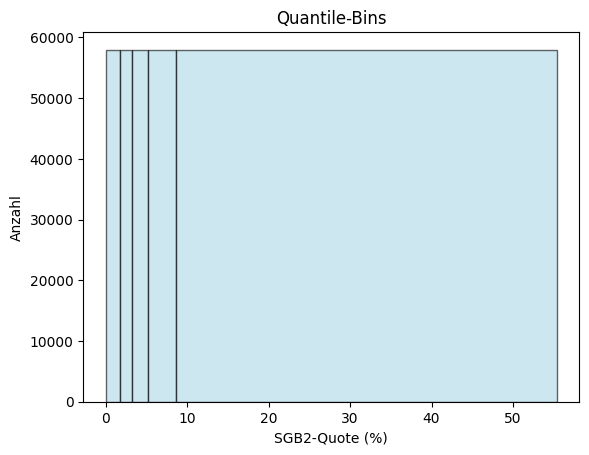

Bin 1: 0.00-1.81, Anzahl: 57966
Bin 2: 1.81-3.28, Anzahl: 57965
Bin 3: 3.28-5.23, Anzahl: 57967
Bin 4: 5.23-8.68, Anzahl: 57966
Bin 5: 8.68-55.36, Anzahl: 57966


In [ ]:
# Anzahl der Bins
num_bins = 5

# Quantile berechnen
quantiles = np.linspace(0, 1, num_bins + 1)
bin_edges = np.quantile(stacked_lb_bev_ue70['SGB2-Quote (%)'], quantiles)

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue70['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Quantile-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(num_bins):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev_ue70['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev_ue70['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Gleichmaessige Intervalle__: Hierbei wird der gesamte Bereich der Daten in gleich grosse Intervalle unterteilt. Diese Einteilung ist leicht verstaendlich, kann jedoch dazu fuehren, dass viele Datenpunkte in ein oder zwei Bins fallen, wenn die Daten stark ungleich verteilt sind.

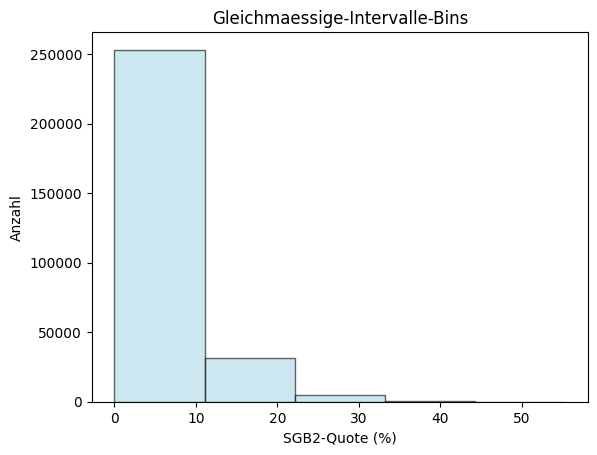

Bin 1: 0.00-11.07, Anzahl: 253059
Bin 2: 11.07-22.14, Anzahl: 31587
Bin 3: 22.14-33.21, Anzahl: 4751
Bin 4: 33.21-44.29, Anzahl: 411
Bin 5: 44.29-55.36, Anzahl: 22


In [ ]:
# Anzahl der Bins
num_bins = 5

# Gleichmaessige Intervalle berechnen
bin_edges = np.linspace(stacked_lb_bev_ue70['SGB2-Quote (%)'].min(), stacked_lb_bev_ue70['SGB2-Quote (%)'].max(), num_bins + 1)

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue70['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Gleichmaessige-Intervalle-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(num_bins):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev_ue70['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev_ue70['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Standardabweichung__: Hierbei werden Bins basierend auf der statistischen Standardabweichung der Daten erstellt. Dies kann hilfreich sein, um zu sehen, welche Datenpunkte signifikant vom Durchschnitt abweichen.

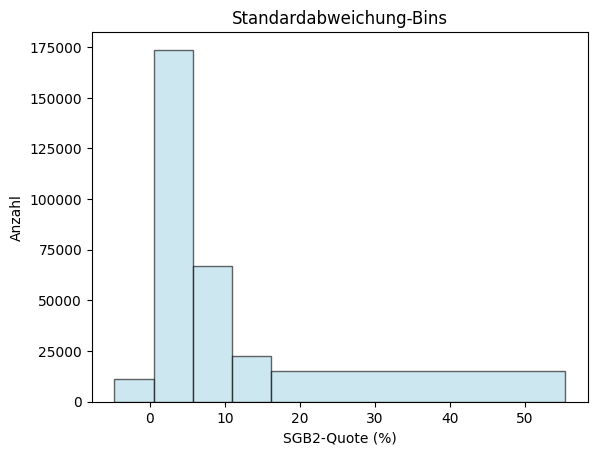

Bin 1: -4.72-0.49, Anzahl: 11322
Bin 2: 0.49-5.71, Anzahl: 173727
Bin 3: 5.71-10.93, Anzahl: 67042
Bin 4: 10.93-16.15, Anzahl: 22775
Bin 5: 16.15-55.36, Anzahl: 14964


In [ ]:
# Anzahl der Bins
num_bins = 5

# Standardabweichung berechnen
mean = stacked_lb_bev_ue70['SGB2-Quote (%)'].mean()
std = stacked_lb_bev_ue70['SGB2-Quote (%)'].std()
bin_edges = [mean - 2*std, mean - std, mean, mean + std, mean + 2*std, stacked_lb_bev_ue70['SGB2-Quote (%)'].max()]

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue70['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Standardabweichung-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(len(bin_edges)-1):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev_ue70['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev_ue70['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Benutzerdefinierte Bins__:  Hier kann der Benutzer die Bins manuell festlegen, auf Grundlage seines Wissens ueber die Struktur der Daten, fachlicher Erwaegungen, seiner Anforderungen an die Visualisierung etc.

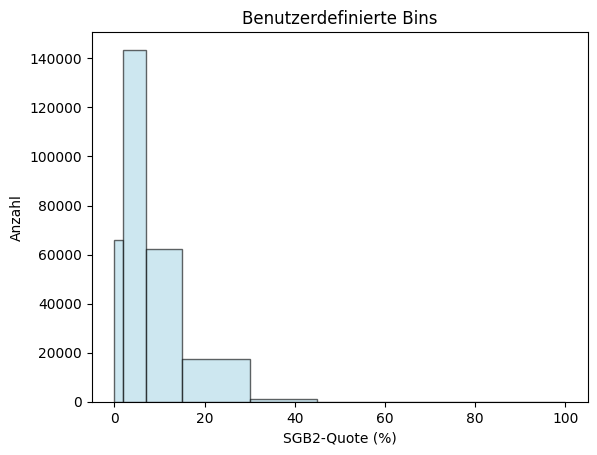

Bin 1: 0-2, Anzahl: 65857
Bin 2: 2-7, Anzahl: 143516
Bin 3: 7-15, Anzahl: 62153
Bin 4: 15-30, Anzahl: 17300
Bin 5: 30-45, Anzahl: 983
Bin 6: 45-100, Anzahl: 22


In [ ]:
# Benutzerdefinierte Bins festlegen
custom_bins = [0, 2, 7, 15, 30, 45, 100]

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue70['SGB2-Quote (%)'], bins=custom_bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Benutzerdefinierte Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(len(custom_bins)-1):
    bin_range = f'{custom_bins[i]}-{custom_bins[i+1]}'
    count = ((stacked_lb_bev_ue70['SGB2-Quote (%)'] >= custom_bins[i]) & (stacked_lb_bev_ue70['SGB2-Quote (%)'] < custom_bins[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Natural-Breaks-Bins__: Die Methode Natural Breaks klassifiziert die Datenpunkte in Klassen basierend auf natuerlichen Gruppen in den Daten selbst. Sie versucht, die Varianz innerhalb der Gruppen zu minimieren und die Varianz zwischen den Gruppen zu maximieren.

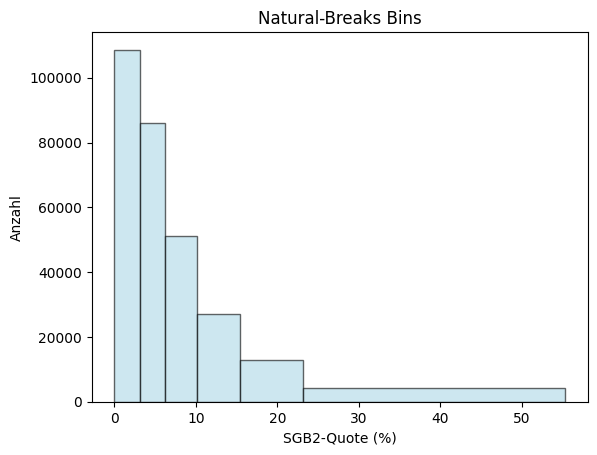

Bin 1: 0.0-3.0760810071154876, Anzahl: 104569
Bin 2: 3.0760810071154876-6.182539682539679, Anzahl: 86157
Bin 3: 6.182539682539679-10.112049209086361, Anzahl: 51051
Bin 4: 10.112049209086361-15.41563275434243, Anzahl: 26929
Bin 5: 15.41563275434243-23.151614412728126, Anzahl: 12730
Bin 6: 23.151614412728126-55.35714285714286, Anzahl: 4312


In [ ]:
# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%)'
data = stacked_lb_bev_ue70['SGB2-Quote (%)'].values

# Berechnen der Bins mit der NaturalBreaks-Methode
classifier = NaturalBreaks(data, k=6)
breaks = classifier.bins
breaks = np.insert(breaks, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=breaks, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Natural-Breaks Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(breaks)-1):
    print(f"Bin {i+1}: {breaks[i]}-{breaks[i+1]}, Anzahl: {((data > breaks[i]) & (data <= breaks[i+1])).sum()}")

__FisherJenks_ bzw. FisherJenksSampled__: Aehnlich wie Natural Breaks, jedoch spezialisiert auf die Anwendung auf eindimensionale Daten; sorgt im Vergleich zu aehnlichen Methoden fuer geringere Abweichungen der Datenpunkte um den jeweiligen Klassen-Median. Bei der "Sampled"-Variante (sinnvoll bei sehr grossen Datenmengen) werden nicht alle Datenpunkte, sondern eine Stichprobe (z. B. 20 % der Faelle) zur Ermittlung der Klassengrenzen beruecksichtigt.

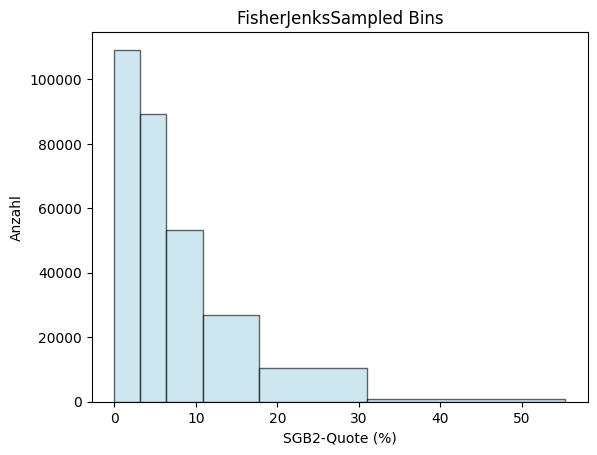

Bin 1: 0.0-3.09044644922508, Anzahl: 105095
Bin 2: 3.09044644922508-6.374038072093962, Anzahl: 89298
Bin 3: 6.374038072093962-10.867697594501703, Anzahl: 53211
Bin 4: 10.867697594501703-17.77613412228796, Anzahl: 26861
Bin 5: 17.77613412228796-31.023911374355638, Anzahl: 10518
Bin 6: 31.023911374355638-55.35714285714286, Anzahl: 765


In [ ]:
# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%)'
data = stacked_lb_bev_ue70['SGB2-Quote (%)'].values

# Berechnen der Bins mit der FisherJenksSampled-Methode
classifier = FisherJenksSampled(data, pct=0.2, k=6)
bins = classifier.bins
bins = np.insert(bins, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('FisherJenksSampled Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(bins)-1):
    print(f"Bin {i+1}: {bins[i]}-{bins[i+1]}, Anzahl: {((data > bins[i]) & (data <= bins[i+1])).sum()}")

## 3.10 Bins fuer 2021 auf Gemeindeebene mit FisherJenks-Methode ermitteln

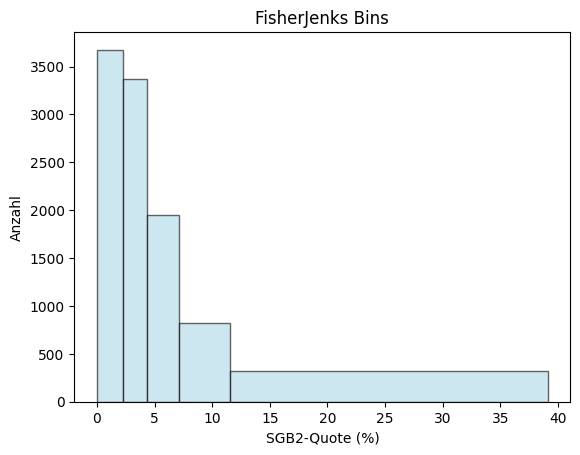

Bin 1: 0.0-2.2687609075043627, Anzahl: 3605
Bin 2: 2.2687609075043627-4.316830641342665, Anzahl: 3372
Bin 3: 4.316830641342665-7.139265962795376, Anzahl: 1954
Bin 4: 7.139265962795376-11.538461538461549, Anzahl: 824
Bin 5: 11.538461538461549-39.1173245614034, Anzahl: 325


In [ ]:
# Daten bereinigen, sodass zusammengefasste SGB2-Quote auf Gemeindeebene fuer das Jahr 2021 verbleibt
data2021_fisher_jenks = stacked_lb_bev_ue70
data2021_fisher_jenks = data2021_fisher_jenks[data2021_fisher_jenks.Jahr == 2021]
data2021_fisher_jenks['LB_Gesamt'] = data2021_fisher_jenks.groupby('Gemeinde')['Anzahl_LB'].transform('sum')
data2021_fisher_jenks['Bev_Gesamt'] = data2021_fisher_jenks.groupby('Gemeinde')['Anzahl_Bevoelkerung'].transform('sum')
data2021_fisher_jenks["SGB2-Quote (%) gesamt"] = (data2021_fisher_jenks["LB_Gesamt"] / data2021_fisher_jenks["Bev_Gesamt"]) * 100
data2021_fisher_jenks = data2021_fisher_jenks[['Gemeinde', 'SGB2-Quote (%) gesamt']]
data2021_fisher_jenks = data2021_fisher_jenks.drop_duplicates()

# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%) gesamt'
data = data2021_fisher_jenks['SGB2-Quote (%) gesamt'].values

# Berechnen der Bins mit der FisherJenks-Methode
classifier = FisherJenks(data, k=5)
bins = classifier.bins
bins = np.insert(bins, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('FisherJenks Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(bins)-1):
    print(f"Bin {i+1}: {bins[i]}-{bins[i+1]}, Anzahl: {((data > bins[i]) & (data <= bins[i+1])).sum()}")

## 3.11 Bins-Spalte ergaenzen

In [ ]:
# Grenzen und Labels fuer die Bins (basierend auf FisherJenks) definieren
bins = [0, 2, 4, 7, 11, 100]
labels = [1, 2, 3, 4, 5]

# Neue 'bins'-Spalte erstellen
stacked_lb_bev_ue70['bins'] = pd.cut(stacked_lb_bev_ue70['SGB2-Quote (%)'], bins=bins, labels=labels)

## 3.12 Problem beheben, das durch 7-stellige AGS bei der Verknuepfung der Daten mit den Shapefiles in tableau entsteht

In [ ]:
# Spalte "AGS" als String definieren
stacked_lb_bev_ue70["AGS"] = stacked_lb_bev_ue70["AGS"].astype(str)

# "0" vor den Eintraegen mit genau 7 Zeichen hinzufuegen
stacked_lb_bev_ue70["AGS"] = stacked_lb_bev_ue70["AGS"].apply(lambda x: '0' + x if len(x) == 7 else x)

## 3.13 AGS fuer Kreisebene ergaenzen (zur Verknuepfung mit den entsprechenden Shapefiles in tableau)

In [ ]:
stacked_lb_bev_ue70['AGS_Kreis'] = stacked_lb_bev_ue70['AGS'].str[:5]

## 3.14 AGS fuer Bundesland ergaenzen (zur Verknuepfung mit den entsprechenden Shapefiles in tableau)

In [ ]:
stacked_lb_bev_ue70['AGS_BL'] = stacked_lb_bev_ue70['AGS'].str[:2]

# 4. Tabelle fuer SBG II-Dynamik-Indikator erstellen

#### Berechnung der Entwicklung der Quote in den Gemeinden in den Jahren 2014 bis 2021

## 4.1 Neues Dataframe erstellen und filtern

In [ ]:
# Neues DataFrame 'sgb_ii_dynamik' als Kopie von 'stacked_lb_bev_ue70' erstellen
sgb_ii_dynamik = stacked_lb_bev_ue70.copy(deep=True)

In [ ]:
# DataFrame 'sgb_ii_dynamik' fuer die Jahre 2014 und 2021 filtern
sgb_ii_dynamik = sgb_ii_dynamik[sgb_ii_dynamik['Jahr'].isin([2014, 2023])]

In [ ]:
# Erste Zeilen des gefilterten DataFrames anzeigen
sgb_ii_dynamik.head(5)

,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung,SGB2-Quote (%),bins,AGS_Kreis,AGS_BL
0,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2014,1055.5,4303.0,24.529398,5,01001,01
9,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2023,1414.25,5135.0,27.541383,5,01001,01
10,01001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2014,414.083333,2280.0,18.16155,5,01001,01
19,01001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2023,422.583333,2430.0,17.390261,5,01001,01
20,01001000,"Flensburg, Stadt",18 bis unter 65 Jahren,2014,7674.166667,54653.0,14.04162,5,01001,01


## 4.2 Nicht benoetigte Spalten entfernen

In [ ]:
# Liste der benoetigten Spalten erstellen
gewuenschte_spalten = ["AGS", "Gemeinde", "Altersgruppe_LB", "Jahr", "Anzahl_LB", "Anzahl_Bevoelkerung", "SGB2-Quote (%)", "AGS_Kreis", "AGS_BL"]

# Nur die benoetigten Spalten uebernehmen
sgb_ii_dynamik = sgb_ii_dynamik.loc[:,gewuenschte_spalten]

In [ ]:
# DataFrame anzeigen
sgb_ii_dynamik.head(5)

,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung,SGB2-Quote (%),AGS_Kreis,AGS_BL
0,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2014,1055.5,4303.0,24.529398,01001,01
9,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2023,1414.25,5135.0,27.541383,01001,01
10,01001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2014,414.083333,2280.0,18.16155,01001,01
19,01001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2023,422.583333,2430.0,17.390261,01001,01
20,01001000,"Flensburg, Stadt",18 bis unter 65 Jahren,2014,7674.166667,54653.0,14.04162,01001,01


## 4.3: Dataframe umstrukturieren mit "pivot"

In [ ]:
# unstack mittels pivot-Methode
sgb_ii_dynamik_unstacked = sgb_ii_dynamik.pivot(index=["AGS", "Gemeinde", "Altersgruppe_LB", "AGS_Kreis", "AGS_BL"],
                                                columns="Jahr",
                                                values=["Anzahl_LB", "Anzahl_Bevoelkerung", "SGB2-Quote (%)"])

# Tabellenkopf anzeigen
sgb_ii_dynamik_unstacked.head()

Anzahl_LB  \
Jahr                                                                            2014   
AGS      Gemeinde               Altersgruppe_LB        AGS_Kreis AGS_BL                
01001000 Flensburg, Stadt       0 bis unter 6 Jahren   01001     01           1055.5   
                                15 bis unter 18 Jahren 01001     01       414.083333   
                                18 bis unter 65 Jahren 01001     01      7674.166667   
                                6 bis unter 15 Jahren  01001     01      1352.416667   
01002000 Kiel, Landeshauptstadt 0 bis unter 6 Jahren   01002     01           3413.5   

                                                                                      \
Jahr                                                                            2023   
AGS      Gemeinde               Altersgruppe_LB        AGS_Kreis AGS_BL                
01001000 Flensburg, Stadt       0 bis unter 6 Jahren   01001     01          1414.25   
                                15 bis unter 18 Jahren 01001     01       422.583333   
                                18 bis unter 65 Jahren 01001     01           7550.0   
                                6 bis unter 15 Jahren  01001     01      1560.333333   
01002000 Kiel, Landeshauptstadt 0 bis unter 6 Jahren   01002     01      3512.083333   

                                                                        Anzahl_Bevoelkerung  \
Jahr                                                                                   2014   
AGS      Gemeinde               Altersgruppe_LB        AGS_Kreis AGS_BL                       
01001000 Flensburg, Stadt       0 bis unter 6 Jahren   01001     01                  4303.0   
                                15 bis unter 18 Jahren 01001     01                  2280.0   
                                18 bis unter 65 Jahren 01001     01                 54653.0   
                                6 bis unter 15 Jahren  01001     01                  6006.0   
01002000 Kiel, Landeshauptstadt 0 bis unter 6 Jahren   01002     01                 12339.0   

                                                                                  \
Jahr                                                                        2023   
AGS      Gemeinde               Altersgruppe_LB        AGS_Kreis AGS_BL            
01001000 Flensburg, Stadt       0 bis unter 6 Jahren   01001     01       5135.0   
                                15 bis unter 18 Jahren 01001     01       2430.0   
                                18 bis unter 65 Jahren 01001     01      59121.0   
                                6 bis unter 15 Jahren  01001     01       7350.0   
01002000 Kiel, Landeshauptstadt 0 bis unter 6 Jahren   01002     01      12762.0   

                                                                        SGB2-Quote (%)  \
Jahr                                                                              2014   
AGS      Gemeinde               Altersgruppe_LB        AGS_Kreis AGS_BL                  
01001000 Flensburg, Stadt       0 bis unter 6 Jahren   01001     01          24.529398   
                                15 bis unter 18 Jahren 01001     01           18.16155   
                                18 bis unter 65 Jahren 01001     01           14.04162   
                                6 bis unter 15 Jahren  01001     01           22.51776   
01002000 Kiel, Landeshauptstadt 0 bis unter 6 Jahren   01002     01          27.664316   

                                                                                    
Jahr                                                                          2023  
AGS      Gemeinde               Altersgruppe_LB        AGS_Kreis AGS_BL             
01001000 Flensburg, Stadt       0 bis unter 6 Jahren   01001     01      27.541383  
                                15 bis unter 18 Jahren 01001     01      17.390261  
                                18 bis unter 65 Jahren 01001     01       12.77042  


In [ ]:
# Spalten-Index Name entfernen
sgb_ii_dynamik_unstacked.columns.name = None

# Spalten temporaer neu benennen, um Multiindex zu entfernen
sgb_ii_dynamik_unstacked.columns = [f"temp_{col}" for col in sgb_ii_dynamik_unstacked.columns]

In [ ]:
# Index zuruecksetzen
sgb_ii_dynamik_unstacked.reset_index(inplace=True)

In [ ]:
# DataFrame anzeigen
sgb_ii_dynamik_unstacked.head(5)


,AGS,Gemeinde,Altersgruppe_LB,AGS_Kreis,AGS_BL,"temp_('Anzahl_LB', 2014)","temp_('Anzahl_LB', 2023)","temp_('Anzahl_Bevoelkerung', 2014)","temp_('Anzahl_Bevoelkerung', 2023)","temp_('SGB2-Quote (%)', 2014)","temp_('SGB2-Quote (%)', 2023)"
0,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,01001,01,1055.5,1414.25,4303.0,5135.0,24.529398,27.541383
1,01001000,"Flensburg, Stadt",15 bis unter 18 Jahren,01001,01,414.083333,422.583333,2280.0,2430.0,18.16155,17.390261
2,01001000,"Flensburg, Stadt",18 bis unter 65 Jahren,01001,01,7674.166667,7550.0,54653.0,59121.0,14.04162,12.77042
3,01001000,"Flensburg, Stadt",6 bis unter 15 Jahren,01001,01,1352.416667,1560.333333,6006.0,7350.0,22.51776,21.229025
4,01002000,"Kiel, Landeshauptstadt",0 bis unter 6 Jahren,01002,01,3413.5,3512.083333,12339.0,12762.0,27.664316,27.519851


## 4.4 Spaltennamen final umbenennen

In [ ]:
# Dictionary fuer Umbenennungen der Spalten erstellen
umbenennungen = {
    "temp_('Anzahl_LB', 2014)": "Anzahl_LB_2014",
    "temp_('Anzahl_LB', 2023)": "Anzahl_LB_2023",
    "temp_('Anzahl_Bevoelkerung', 2014)": "Anzahl_Bevoelkerung_2014",
    "temp_('Anzahl_Bevoelkerung', 2023)": "Anzahl_Bevoelkerung_2023",
    "temp_('SGB2-Quote (%)', 2014)": "SGB2-Quote (%)_2014",
    "temp_('SGB2-Quote (%)', 2023)": "SGB2-Quote (%)_2023"
}

In [ ]:
# Umbenennungen auf die Spalten anwenden
sgb_ii_dynamik_unstacked.rename(columns=umbenennungen, inplace=True)

In [ ]:
# DataFrame anzeigen
sgb_ii_dynamik_unstacked.head(5)

,AGS,Gemeinde,Altersgruppe_LB,AGS_Kreis,AGS_BL,Anzahl_LB_2014,Anzahl_LB_2023,Anzahl_Bevoelkerung_2014,Anzahl_Bevoelkerung_2023,SGB2-Quote (%)_2014,SGB2-Quote (%)_2023
0,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,01001,01,1055.5,1414.25,4303.0,5135.0,24.529398,27.541383
1,01001000,"Flensburg, Stadt",15 bis unter 18 Jahren,01001,01,414.083333,422.583333,2280.0,2430.0,18.16155,17.390261
2,01001000,"Flensburg, Stadt",18 bis unter 65 Jahren,01001,01,7674.166667,7550.0,54653.0,59121.0,14.04162,12.77042
3,01001000,"Flensburg, Stadt",6 bis unter 15 Jahren,01001,01,1352.416667,1560.333333,6006.0,7350.0,22.51776,21.229025
4,01002000,"Kiel, Landeshauptstadt",0 bis unter 6 Jahren,01002,01,3413.5,3512.083333,12339.0,12762.0,27.664316,27.519851


## 4.5: Ergebnisse ueberpruefen

In [ ]:
# Anzahl der NaN-Werte in den Spalten "Anzahl_Bevoelkerung" und "Anzahl_LB" berechnen
anzahl_nan_anzahl_bevoelkerung = sgb_ii_dynamik_unstacked['Anzahl_Bevoelkerung_2014'].isna().sum()
anzahl_nan_anzahl_lb = sgb_ii_dynamik_unstacked['Anzahl_LB_2014'].isna().sum()

In [ ]:
# Ergebnisse anzeigen
print(f"Anzahl NaN-Werte Bevoelkerung': {anzahl_nan_anzahl_bevoelkerung}")
print(f"Anzahl NaN-Werte LB': {anzahl_nan_anzahl_lb}")

Anzahl NaN-Werte Bevoelkerung': 1697
Anzahl NaN-Werte LB': 1697


## 4.6: Fehlersuche und -loesung

In [ ]:
# Anzahl der NaN-Werte im urspruenglichen Dataframe pruefen
anzahl_nan_vor_pivot = stacked_lb_bev_ue70['Anzahl_Bevoelkerung'].isna().sum()
anzahl_nan_vor_pivot

np.int64(0)

In [ ]:
# Anzahl der NaN-Werte im pivotierten Dataframe pruefen
anzahl_nan_nach_pivot = sgb_ii_dynamik_unstacked['Anzahl_Bevoelkerung_2014'].isna().sum()
anzahl_nan_nach_pivot

np.int64(1697)

In [ ]:
# Stichprobenartige Auswahl von zehn Zeilen, in denen 'Anzahl_Bevoelkerung_2014' oder 'Anzahl_LB_2014' == NaN ist, anzeigen
stichprobe_nan = sgb_ii_dynamik_unstacked[
    sgb_ii_dynamik_unstacked['Anzahl_Bevoelkerung_2014'].isna() |
    sgb_ii_dynamik_unstacked['Anzahl_LB_2014'].isna()
].sample(10)

stichprobe_nan.head()

,AGS,Gemeinde,Altersgruppe_LB,AGS_Kreis,AGS_BL,Anzahl_LB_2014,Anzahl_LB_2023,Anzahl_Bevoelkerung_2014,Anzahl_Bevoelkerung_2023,SGB2-Quote (%)_2014,SGB2-Quote (%)_2023
3387,03257004,Auhagen,0 bis unter 6 Jahren,03257,03,NaN,3.083333,NaN,90.0,NaN,3.425926
26389,13075151,"Zinnowitz, Ostseebad",15 bis unter 18 Jahren,13075,13,NaN,7.333333,NaN,95.0,NaN,7.719298
16089,08425019,Bernstadt,15 bis unter 18 Jahren,08425,08,NaN,1,NaN,73.0,NaN,1.369863
29244,16063103,"Werra-Suhl-Tal, Stadt",18 bis unter 65 Jahren,16063,16,NaN,82.333333,NaN,3549.0,NaN,2.319902
1074,01058026,Bovenau,0 bis unter 6 Jahren,01058,01,NaN,0.333333,NaN,78.0,NaN,0.42735


In [ ]:
# Zeilen mit NaN-Werten in den genannten Spalten entfernen
sgb_ii_dynamik_cleaned = sgb_ii_dynamik_unstacked.dropna(subset=['Anzahl_Bevoelkerung_2014', 'Anzahl_LB_2014', 'Anzahl_Bevoelkerung_2023', 'Anzahl_LB_2023'])

In [ ]:
# Bereinigtes DataFrame ueberpruefen
sgb_ii_dynamik_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27207 entries, 0 to 30558
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   AGS                       27207 non-null  object
 1   Gemeinde                  27207 non-null  object
 2   Altersgruppe_LB           27207 non-null  object
 3   AGS_Kreis                 27207 non-null  object
 4   AGS_BL                    27207 non-null  object
 5   Anzahl_LB_2014            27207 non-null  object
 6   Anzahl_LB_2023            27207 non-null  object
 7   Anzahl_Bevoelkerung_2014  27207 non-null  object
 8   Anzahl_Bevoelkerung_2023  27207 non-null  object
 9   SGB2-Quote (%)_2014       27207 non-null  object
 10  SGB2-Quote (%)_2023       27207 non-null  object
dtypes: object(11)
memory usage: 2.5+ MB


In [ ]:
# Fertiges DataFrame umbenennen und die ersten Zeilen anzeigen
sgb_ii_dynamik_unstacked = sgb_ii_dynamik_cleaned
sgb_ii_dynamik_unstacked.head()

,AGS,Gemeinde,Altersgruppe_LB,AGS_Kreis,AGS_BL,Anzahl_LB_2014,Anzahl_LB_2023,Anzahl_Bevoelkerung_2014,Anzahl_Bevoelkerung_2023,SGB2-Quote (%)_2014,SGB2-Quote (%)_2023
0,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,01001,01,1055.5,1414.25,4303.0,5135.0,24.529398,27.541383
1,01001000,"Flensburg, Stadt",15 bis unter 18 Jahren,01001,01,414.083333,422.583333,2280.0,2430.0,18.16155,17.390261
2,01001000,"Flensburg, Stadt",18 bis unter 65 Jahren,01001,01,7674.166667,7550.0,54653.0,59121.0,14.04162,12.77042
3,01001000,"Flensburg, Stadt",6 bis unter 15 Jahren,01001,01,1352.416667,1560.333333,6006.0,7350.0,22.51776,21.229025
4,01002000,"Kiel, Landeshauptstadt",0 bis unter 6 Jahren,01002,01,3413.5,3512.083333,12339.0,12762.0,27.664316,27.519851


## 4.7: Daten aggregieren in Vorbereitung der Berechnung der Quoten und Klassifizierung

In [ ]:
# Daten basierend auf Altersgruppen aggregieren
aggregierte_daten = sgb_ii_dynamik_cleaned.groupby(['AGS', 'Gemeinde', 'AGS_Kreis', 'AGS_BL']).agg({
    'Anzahl_LB_2014': 'sum',
    'Anzahl_LB_2023': 'sum',
    'Anzahl_Bevoelkerung_2014': 'sum',
    'Anzahl_Bevoelkerung_2023': 'sum',
}).reset_index()

In [ ]:
# Aggregierte Tabelle anzeigen
sgb_ii_dynamik_cleaned.head()

,AGS,Gemeinde,Altersgruppe_LB,AGS_Kreis,AGS_BL,Anzahl_LB_2014,Anzahl_LB_2023,Anzahl_Bevoelkerung_2014,Anzahl_Bevoelkerung_2023,SGB2-Quote (%)_2014,SGB2-Quote (%)_2023
0,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,01001,01,1055.5,1414.25,4303.0,5135.0,24.529398,27.541383
1,01001000,"Flensburg, Stadt",15 bis unter 18 Jahren,01001,01,414.083333,422.583333,2280.0,2430.0,18.16155,17.390261
2,01001000,"Flensburg, Stadt",18 bis unter 65 Jahren,01001,01,7674.166667,7550.0,54653.0,59121.0,14.04162,12.77042
3,01001000,"Flensburg, Stadt",6 bis unter 15 Jahren,01001,01,1352.416667,1560.333333,6006.0,7350.0,22.51776,21.229025
4,01002000,"Kiel, Landeshauptstadt",0 bis unter 6 Jahren,01002,01,3413.5,3512.083333,12339.0,12762.0,27.664316,27.519851


## 4.8: Quoten und Dynamik berechnen

In [ ]:
# neue Spalte "SGB2_Quote_2014" erzeugen
aggregierte_daten['SGB2_Quote_2014'] = (aggregierte_daten['Anzahl_LB_2014'] / aggregierte_daten['Anzahl_Bevoelkerung_2014']) * 100

# neue Spalte "SGB2_Quote_2021" erzeugen
aggregierte_daten['SGB2_Quote_2023'] = (aggregierte_daten['Anzahl_LB_2023'] / aggregierte_daten['Anzahl_Bevoelkerung_2023']) * 100

# neue Spalte "Veraenderung" erzeugen
aggregierte_daten['Veraenderung'] = (aggregierte_daten['SGB2_Quote_2023'] - aggregierte_daten['SGB2_Quote_2014'] )

# aggregierte Tabelle mit Veraenderung anzeigen
aggregierte_daten.head()

,AGS,Gemeinde,AGS_Kreis,AGS_BL,Anzahl_LB_2014,Anzahl_LB_2023,Anzahl_Bevoelkerung_2014,Anzahl_Bevoelkerung_2023,SGB2_Quote_2014,SGB2_Quote_2023,Veraenderung
0,01001000,"Flensburg, Stadt",01001,01,10496.166667,10947.166667,67242.0,74036.0,15.60954,14.786275,-0.823265
1,01002000,"Kiel, Landeshauptstadt",01002,01,32020.083333,30319.75,198419.0,201405.0,16.137609,15.05412,-1.08349
2,01003000,"Lübeck, Hansestadt",01003,01,27435.25,22987.583333,164768.0,167739.0,16.650836,13.704376,-2.94646
3,01004000,"Neumünster, Stadt",01004,01,10314.75,8801.916667,60022.0,61809.0,17.184949,14.24051,-2.944439
4,01051001,Albersdorf,01051,01,387.083333,288.083333,2604.0,2918.0,14.864951,9.87263,-4.992322


## 4.9: Intervalle fuer die Darstellung der Dynamik auf der Karte berechnen

In [ ]:
# Mittelwert und Standardabweichung der Werte in der Spalte "Veraenderung" berechnen
mittelwert_veraenderung = aggregierte_daten['Veraenderung'].mean()
standardabweichung_veraenderung = aggregierte_daten['Veraenderung'].std()

In [ ]:
# Ergebnisse anzeigen
print(f"Mittelwert der Veraenderung: {mittelwert_veraenderung}")
print(f"Standardabweichung der Veraenderung: {standardabweichung_veraenderung}")

Mittelwert der Veraenderung: -1.2265123379581884
Standardabweichung der Veraenderung: 2.300430062498707


In [ ]:
# Definition der Intervalle
print(f"Intervall fuer stabile Entwicklung: von {mittelwert_veraenderung - standardabweichung_veraenderung} bis {mittelwert_veraenderung + standardabweichung_veraenderung}")
print(f"Steigende Entwicklung: ab {mittelwert_veraenderung + standardabweichung_veraenderung}")
print(f"Abnehmende Entwicklung: ab {mittelwert_veraenderung - standardabweichung_veraenderung}")


Intervall fuer stabile Entwicklung: von -3.526942400456895 bis 1.0739177245405187
Steigende Entwicklung: ab 1.0739177245405187
Abnehmende Entwicklung: ab -3.526942400456895


# 5. Fertige Tabellen exportieren als Excel und CSV

In [ ]:
# Für den Export einer in Tableau funktionierenden CSV-Datei werden abschließend die Dezimaltrenner von Punkten auf Kommata umgestellt

# Liste der Zielspalten
target_columns = [
    "Anzahl_LB_2014",
    "Anzahl_LB_2023",
    "Anzahl_Bevoelkerung_2014",
    "Anzahl_Bevoelkerung_2023",
    "SGB2-Quote (%)_2014",
    "SGB2-Quote (%)_2023"
]

# Ersetzen der Punkte durch Kommata in den genannten Spalten
for col in target_columns:
    if col in sgb_ii_dynamik_unstacked.columns:
        sgb_ii_dynamik_unstacked[col] = (
            sgb_ii_dynamik_unstacked[col]
            .astype(str)
            .str.replace(".", ",", regex=False)
        )

# Entfernen der nicht mehr benötigten Spalten (für eine aus Gründen der Performance möglichst schmale Datentabelle in Tableau)
columns_to_drop = ["SGB2-Quote (%)_2014", "SGB2-Quote (%)_2023"]
sgb_ii_dynamik_unstacked = sgb_ii_dynamik_unstacked.drop(columns=[col for col in columns_to_drop if col in sgb_ii_dynamik_unstacked.columns])

In [ ]:
sgb_ii_dynamik_unstacked.head()

,AGS,Gemeinde,Altersgruppe_LB,AGS_Kreis,AGS_BL,Anzahl_LB_2014,Anzahl_LB_2023,Anzahl_Bevoelkerung_2014,Anzahl_Bevoelkerung_2023
0,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,01001,01,"1055,5","1414,25","4303,0","5135,0"
1,01001000,"Flensburg, Stadt",15 bis unter 18 Jahren,01001,01,"414,08333333333303","422,583333333334","2280,0","2430,0"
2,01001000,"Flensburg, Stadt",18 bis unter 65 Jahren,01001,01,"7674,166666666663","7549,999999999996","54653,0","59121,0"
3,01001000,"Flensburg, Stadt",6 bis unter 15 Jahren,01001,01,"1352,416666666666","1560,333333333334","6006,0","7350,0"
4,01002000,"Kiel, Landeshauptstadt",0 bis unter 6 Jahren,01002,01,"3413,5","3512,083333333334","12339,0","12762,0"


In [ ]:
# DataFrame stacked_elb_schul speichern
stacked_elb_schul_ue70.to_excel('elb_quote_schul_ue70.xlsx', index=False)
stacked_elb_schul_ue70.to_csv('elb_quote_schul_ue70.csv', index=False)

# DataFrame stacked_elb_beruf speichern
stacked_elb_beruf_ue70.to_excel('elb_quote_beruf_ue70.xlsx', index=False)
stacked_elb_beruf_ue70.to_csv('elb_quote_beruf_ue70.csv', index=False)

# DataFrame stacked_lb_bev speichern
stacked_lb_bev.to_excel('sgb2_quote.xlsx', index=False)
stacked_lb_bev.to_csv('sgb2_quote.csv', index=False)
stacked_lb_bev_ue70.to_excel('sgb2_quote_ue70.xlsx', index=False)
stacked_lb_bev_ue70.to_csv('sgb2_quote_ue70.csv', index=False)

# Dynamik-Indikator speichern
sgb_ii_dynamik_unstacked.to_excel('sgb_ii_status_dynamik_V3.2.xlsx', index=False)
sgb_ii_dynamik_unstacked.to_csv('sgb_ii_status_dynamik_V3.2.csv', index=False, encoding="utf-8", sep=",")

In [ ]:
# Dynamik-Indikator speichern
sgb_ii_dynamik_unstacked.to_excel('sgb_ii_status_dynamik_V3.2.xlsx', index=False)
sgb_ii_dynamik_unstacked.to_csv('sgb_ii_status_dynamik_V3.2.csv', index=False, encoding="utf-8", sep=",")

# 6. Diagramme zur Darstellung der Verteilung und Klassifizierung auf der Themenseite erzeugen

## 6.1 Statusindikator

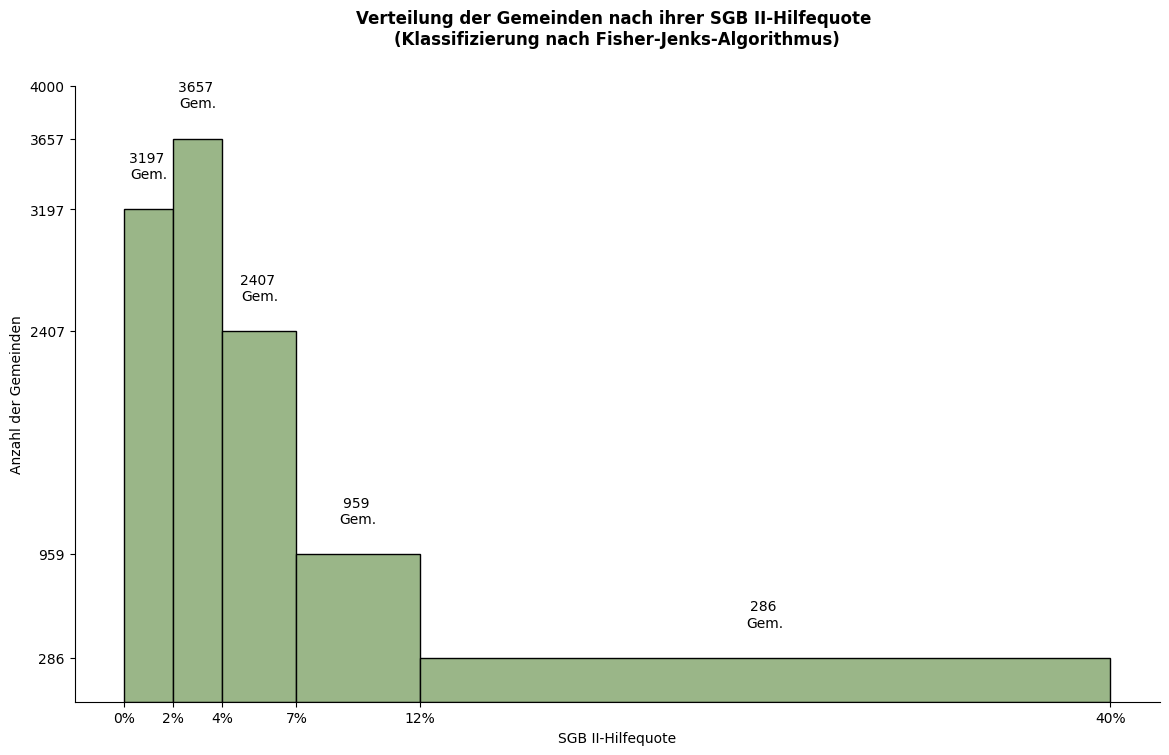

In [ ]:
# Daten vorbereiten
bins = [0, 2, 4, 7, 12, 40] #Rundung der Klassen auf ganze Zahlen
counts = [3197, 3657, 2407, 959, 286] #Die Anzahl der hier angegebenen Gemeinden pro Klasse wird in Tableau berechnet

# Breiten der Bins berechnen
bin_widths = [bins[i+1] - bins[i] for i in range(len(bins)-1)]

# Groesse des Plots anpassen
plt.figure(figsize=(14,8))

# Histogramm erstellen
bars = plt.bar(bins[:-1], counts, width=bin_widths, color='#9AB688', edgecolor='black', align='edge')

# Achsenbezeichnungen festlegen
plt.xlabel('SGB II-Hilfequote')
plt.ylabel('Anzahl der Gemeinden')

# Titel hinzufuegen
plt.title('Verteilung der Gemeinden nach ihrer SGB II-Hilfequote \n(Klassifizierung nach Fisher-Jenks-Algorithmus)',
          fontweight='semibold', pad=30)

# Y-Achse Limit und Ticks einstellen
plt.ylim(0, 4000)
plt.yticks(counts + [4000])

# X-Achse Ticks und Labels einstellen
plt.xticks(bins, [f'{bins[i]}%' for i in range(len(bins))])

# Histogrammbalkenbeschriftung hinzufuegen
for bar, count in zip(bars, counts):
    # Position der Beschriftung in der Mitte des Balkens berechnen
    x = bar.get_x() + bar.get_width() / 2
    y = count

    # Text hinzufuegen
    plt.text(x, y + 200, f"{locale.format_string('%d', count, grouping=True)} \nGem.", color='black', ha='center')

plt.grid(False)

# Rahmenlinien entfernen
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ticks aktivieren
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Diagramm als Bilddatei speichern
plt.savefig('Histogramm_weiss_balken_gruen.png', dpi=300, bbox_inches='tight')

plt.show()

## 6.2 Dynamikindikator

In [ ]:
# Grenzwerte für die Klasseneinteilung festlegen
start_abnehmend = aggregierte_daten['Veraenderung'].min()
untergrenze_abnehmend = -3.5422641895488765
obergrenze_stabil = 1.093529746625937
obergrenze_steigend = aggregierte_daten['Veraenderung'].max()

# Berechnung der Klassenzugehoerigkeiten
# Gemeinden mit abnehmender Entwicklung
anzahl_abnehmend = (aggregierte_daten['Veraenderung'] < untergrenze_abnehmend).sum()

# Gemeinden mit stabiler Entwicklung
anzahl_stabil = ((aggregierte_daten['Veraenderung'] >= untergrenze_abnehmend) &
                 (aggregierte_daten['Veraenderung'] <= obergrenze_stabil)).sum()

# Gemeinden mit steigender Entwicklung
anzahl_steigend = (aggregierte_daten['Veraenderung'] > obergrenze_stabil).sum()

# Ergebnis der Klasseneinteilung anzeigen
aggregierte_daten_klassifiziert = pd.DataFrame({
    'Klasse': ['Abnehmende Entwicklung', 'Stabile Entwicklung', 'Steigende Entwicklung'],
    'Anzahl': [anzahl_abnehmend, anzahl_stabil, anzahl_steigend]
})

aggregierte_daten_klassifiziert.head()

,Klasse,Anzahl
0,Abnehmende Entwicklung,1438
1,Stabile Entwicklung,8087
2,Steigende Entwicklung,671


In [ ]:
# Einstellen des Locale, um Zahlen formatiert auszugeben
locale.setlocale(locale.LC_ALL, 'de_DE')

# Daten vorbereiten
bins = [start_abnehmend, untergrenze_abnehmend, obergrenze_stabil, obergrenze_steigend]  # Endwerte des letzten Balkens anpassen
counts = [anzahl_abnehmend, anzahl_stabil, anzahl_steigend]

# Breiten der Bins berechnen
bin_widths = [bins[i+1] - bins[i] for i in range(len(bins)-1)]

# Groesse des Plots anpassen
plt.figure(figsize=(14,8))

# Histogramm erstellen
bars = plt.bar(bins[:-1], counts, width=bin_widths, color='#9AB688', edgecolor='black', align='edge')

# Achsenbezeichnungen festlegen
plt.xlabel('Veraenderungswerte')
plt.ylabel('Anzahl der Gemeinden')

# Titel hinzufügen
plt.title('Verteilung der Gemeinden nach Veraenderungswerten', fontweight='semibold', pad=30)

# Y-Achse Limit und Ticks einstellen
max_count = max(counts)
plt.ylim(0, max_count + 500)  # Etwas Raum über dem höchsten Balken lassen
plt.yticks(counts + [max_count + 500])

# X-Achse Ticks und Labels einstellen
plt.xticks(bins, [f'{b:.2f}' for b in bins])

# Histogrammbalkenbeschriftung hinzufügen
for bar, count in zip(bars, counts):
    # Position der Beschriftung in der Mitte des Balkens berechnen
    x = bar.get_x() + bar.get_width() / 2
    y = count

    # Text hinzufuegen
    plt.text(x, y + 50, f"{locale.format_string('%d', count, grouping=True)} \nGem.", color='black', ha='center')

plt.grid(False)

# Rahmenlinien entfernen
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ticks aktivieren
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Diagramm anzeigen
plt.show()

Error: unsupported locale setting

# 7. Optionale kreisspezifische Anpassung der Daten

In [ ]:
# Bereinigung und Speicherung der Daten, sodass nur die Daten für einen spezifischen Kreis erhalten bleiben (Beispiel hier: Kreis Segeberg)

# Range der AGS für alle Gemeinden im spezifischen Kreis angeben (hier: AGS aller Gemeinden im Kreis Segeberg)
# Hinweis: Je nach Datensatz kann eine führende 0 vor dem String erforderlich sein.
stacked_lb_bev['AGS'] = stacked_lb_bev['AGS'].astype(str)
stacked_lb_bev_ue70['AGS'] = stacked_lb_bev_ue70['AGS'].astype(str)
sgb_ii_dynamik_unstacked['AGS'] = sgb_ii_dynamik_unstacked['AGS'].astype(str)

min_value = '1060002'
max_value = '1060101'

# Datensätze für spezifischen Kreis erstellen (hier: Kreis Segeberg)
stacked_lb_bev_Segeberg = stacked_lb_bev[(stacked_lb_bev['AGS'] >= min_value) & (stacked_lb_bev['AGS'] <= max_value)]
print(stacked_lb_bev_Segeberg)

min_value_ue70 = '01060002'
max_value_ue70 = '01060101'

stacked_lb_bev_ue70_Segeberg = stacked_lb_bev_ue70[(stacked_lb_bev_ue70['AGS'] >= min_value_ue70) & (stacked_lb_bev_ue70['AGS'] <= max_value_ue70)]
print (stacked_lb_bev_ue70_Segeberg)

min_value_dynamik = '01060002'
max_value_dynamik = '01060101'

sgb_ii_dynamik_unstacked_Segeberg = sgb_ii_dynamik_unstacked[(sgb_ii_dynamik_unstacked['AGS'] >= min_value_dynamik) & (sgb_ii_dynamik_unstacked['AGS'] <= max_value_dynamik)]
print (sgb_ii_dynamik_unstacked_Segeberg)

# Daten speichern
stacked_lb_bev_Segeberg.to_excel('sgb2_quote_Segeberg.xlsx', index=False)
stacked_lb_bev_Segeberg.to_csv('sgb2_quote_Segeberg.csv', index=False)
stacked_lb_bev_ue70_Segeberg.to_excel('sgb2_quote_ue70_Segeberg.xlsx', index=False)
stacked_lb_bev_ue70_Segeberg.to_csv('sgb2_quote_ue70_Segeberg.csv', index=False)

# Dynamik-Indikator speichern
sgb_ii_dynamik_unstacked_Segeberg.to_excel('sgb_ii_dynamik_unstacked_Segeberg.xlsx', index=False)
sgb_ii_dynamik_unstacked_Segeberg.to_csv('sgb_ii_dynamik_unstacked_Segeberg.csv', index=False)